# Домашне завдання №3 (2-1): Побудова лінійної регресії за однією ознакою 

## Ольга Шапошник

В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import probplot

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?


In [73]:
# візбмемо ф-цію з попередньої дз
def rmse_my(target, predict, w, b):
    substraction = predict-target
    square = np.square(substraction)
    sum = np.sum(square)
    devide = sum/len(target)
    root = np.sqrt(devide)
    print(f'Params: (w={w}, b={b}), RMSE = {root}')
    return root

In [74]:
def residuals_plot(target, predict):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist((target-predict))
    plt.subplot(1,2,2)
    probplot((target-predict), dist='norm', plot=plt);

In [75]:
path = "../../../data/medical-charges.csv"
medical_df = pd.read_csv(path)
medical_df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [76]:
non_smoker_df = medical_df[medical_df.smoker == 'no']
non_smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


In [77]:
X = non_smoker_df.age
y = non_smoker_df.charges
 
X_with_intercept = np.c_[np.ones((X.shape[0], 1)), X]
print(X.shape, X_with_intercept.shape, y.shape)

(1064,) (1064, 2) (1064,)


## Методу МНК 

In [78]:
def normal_equations(X,y):
    """Computes the closed-form solution to linear regression"""
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [79]:
MNK_coefs = normal_equations(X_with_intercept, y)
print(f'MNK coef.: {MNK_coefs}')

y_pred_MNK = X_with_intercept.dot(MNK_coefs)
rmse_MNK = rmse_my(y, y_pred_MNK, MNK_coefs[1], MNK_coefs[0])

MNK coef.: [-2091.42055657   267.24891283]
Params: (w=267.24891283119973, b=-2091.4205565650805), RMSE = 4662.505766636395


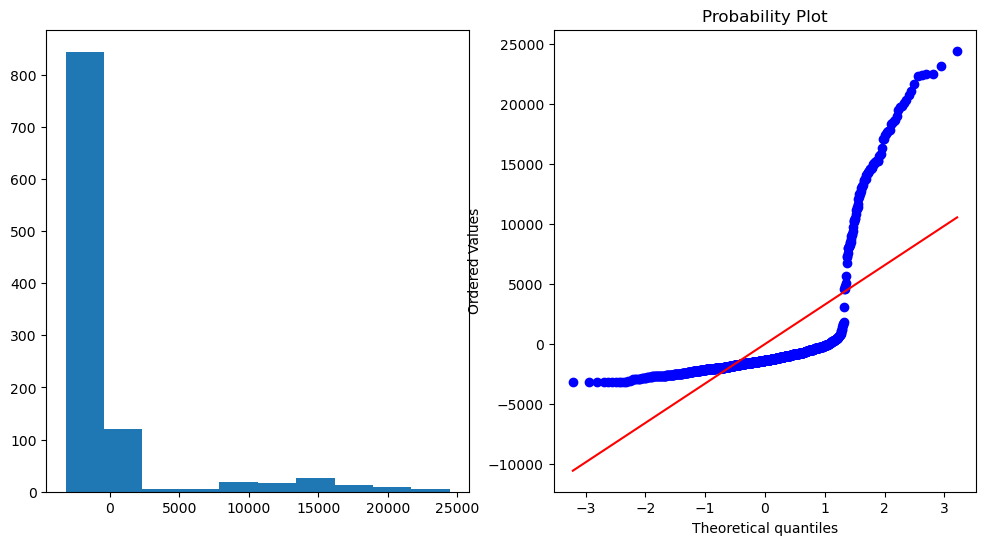

In [80]:
residuals_plot(y, y_pred_MNK)

## Full-Batch градієнтного спуску з `numpy` 

Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.

In [81]:
# Градієнтний спуск
def full_batch_gradient_descent(X, y, lr=0.1, epochs=100):
    m, b = 0.0, 0.0  # Початкові параметри
    n = len(y)
    errors = []
    for _ in range(epochs):
        y_pred = m * X[:, 0] + b
        error = y_pred - y
        errors.append(sum(error**2))
        m_gradient = (2/n) * np.dot(error, X[:, 0])
        b_gradient = (2/n) * np.sum(error)
        m = m - lr * m_gradient
        b = b - lr * b_gradient
    return m, b, errors

In [83]:
m_1, b_1, errors1 = full_batch_gradient_descent(np.expand_dims(X, axis=1), y, lr=0.001, epochs=1000)
print(f'Gradient descent coef. lr=0.001: (m={m_1}, b={b_1})')
m_2, b_2, errors2 = full_batch_gradient_descent(np.expand_dims(X, axis=1), y, lr=0.0001, epochs=1000)
print(f'Gradient descent coef. lr=0.0001: (m={m_2}, b={b_2})')
m_3, b_3, errors3 = full_batch_gradient_descent(np.expand_dims(X, axis=1), y, lr=0.00001, epochs=1000)
print(f'Gradient descent coef .lr=0.00001: (m={m_3}, b={b_3})')


C:\Users\Olha Shaposhnyk\AppData\Local\Temp\ipykernel_311532\4068746268.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  m = m - lr * m_gradient


Gradient descent coef. lr=0.001: (m=nan, b=inf)
Gradient descent coef. lr=0.0001: (m=221.1045843794301, b=-41.98126853149978)
Gradient descent coef .lr=0.00001: (m=220.15455551129122, b=0.2130065279986326)


In [84]:
y_pred_fbgd_1 = m_1 * X + b_1
rmse_fbgd_1 = rmse_my(y, y_pred_fbgd_1, m_1, b_1)

# найкращий результат
y_pred_fbgd_2 = m_2 * X + b_2
rmse_fbgd_2 = rmse_my(y, y_pred_fbgd_2, m_2, b_2)

y_pred_fbgd_3 = m_3 * X + b_3
rmse_fbgd_3 = rmse_my(y, y_pred_fbgd_3, m_3, b_3)


Params: (w=nan, b=inf), RMSE = 0.0
Params: (w=221.1045843794301, b=-41.98126853149978), RMSE = 4713.250582815521
Params: (w=220.15455551129122, b=0.2130065279986326), RMSE = 4715.349750127827


Text(0, 0.5, 'Error')

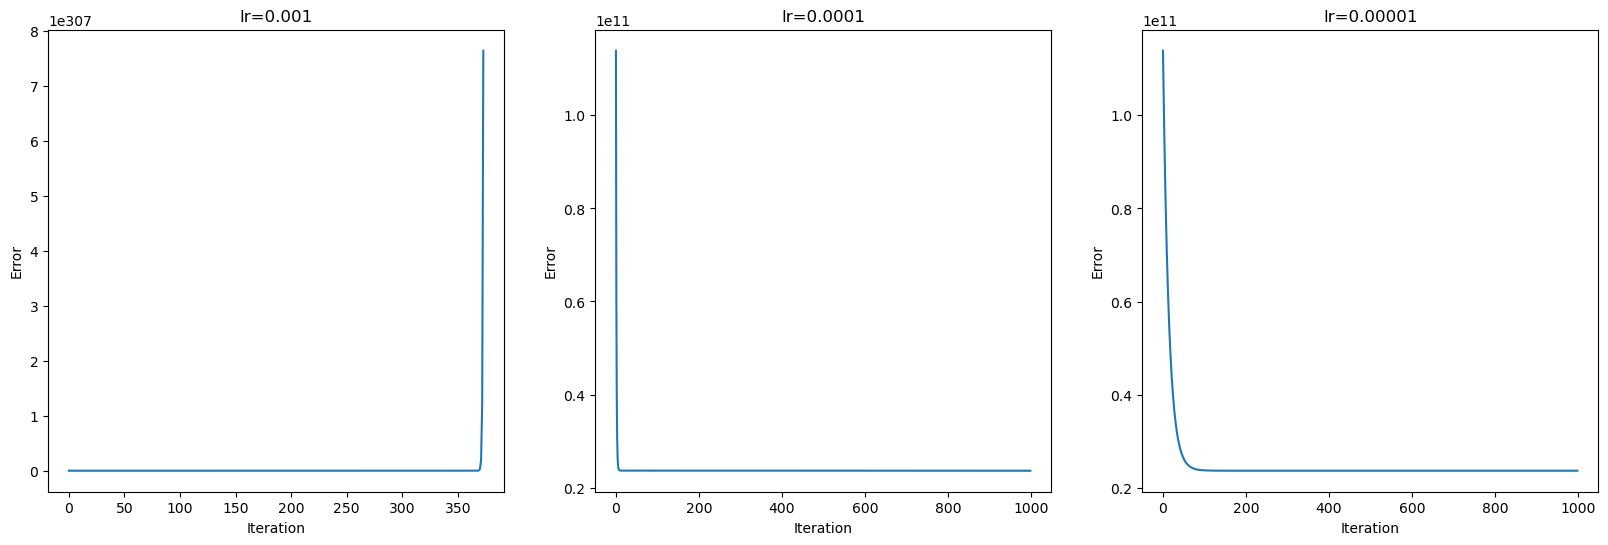

In [85]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.plot(errors1)   
plt.title('lr=0.001')
plt.xlabel('Iteration')
plt.ylabel('Error')

plt.subplot(1, 3, 2)
plt.plot(errors2)
plt.title('lr=0.0001')
plt.xlabel('Iteration')
plt.ylabel('Error')

plt.subplot(1, 3, 3)
plt.plot(errors3)
plt.title('lr=0.00001')
plt.xlabel('Iteration')
plt.ylabel('Error')

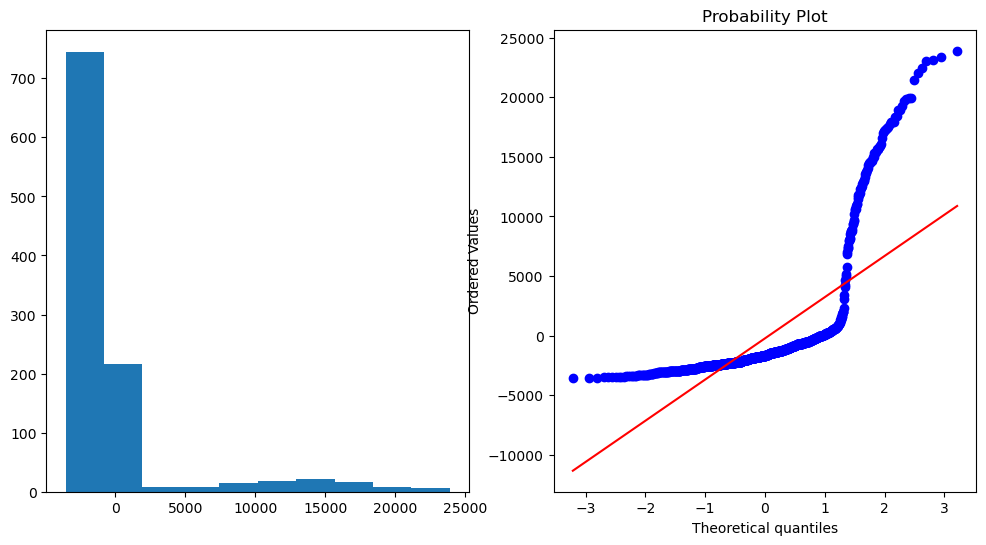

In [86]:
residuals_plot(y, y_pred_fbgd_2)

## scikit-learn.LinearRegression

In [87]:
# X.values.reshape(-1, 1)

In [88]:
regression = LinearRegression()
regression.fit(X.to_frame(), y)

y_pred_sklearn = regression.predict(X.to_frame())
rmse_sklearn = rmse_my(y, y_pred_sklearn, regression.coef_[0], regression.intercept_)

Params: (w=267.24891283119956, b=-2091.4205565650827), RMSE = 4662.505766636395


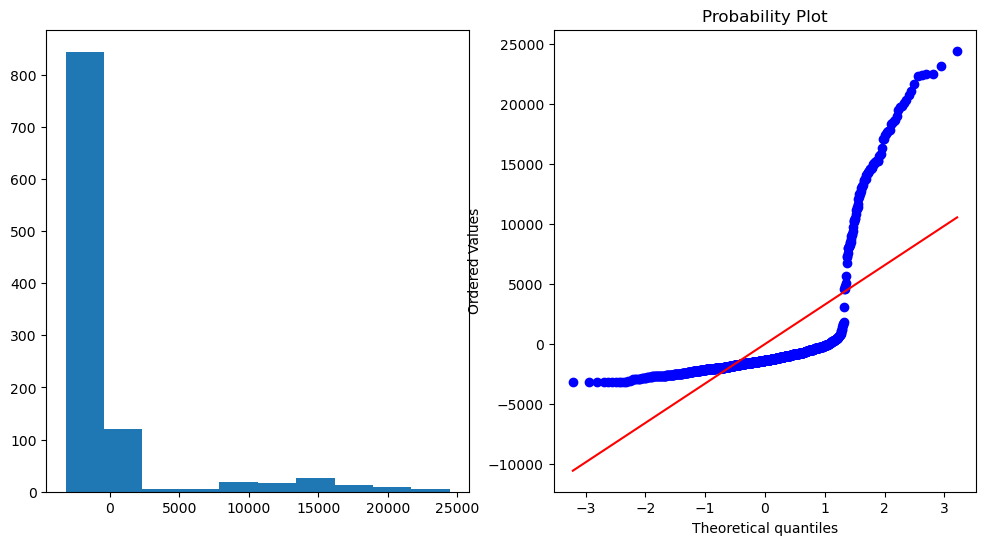

In [89]:
residuals_plot(y, y_pred_sklearn)

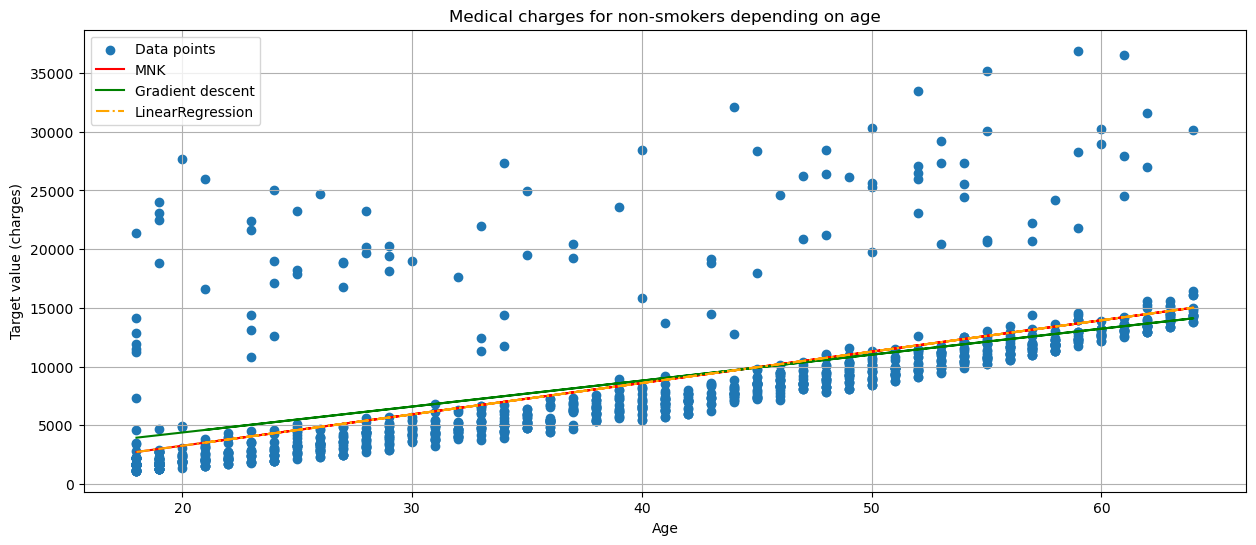

In [90]:
plt.figure(figsize=(15, 6))
plt.scatter(X, y, label='Data points')
plt.plot(X, y_pred_MNK, color='red', label='MNK')
plt.plot(X, y_pred_fbgd_2, color='green', label='Gradient descent')
#змінемо стиль лінії на приривчатиий аби зрозуміти які лінії накладаються
plt.plot(X, y_pred_sklearn, color='orange', label='LinearRegression', linestyle = 'dashdot')
plt.title('Medical charges for non-smokers depending on age')
plt.xlabel('Age')
plt.ylabel('Target value (charges)')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
print(f'ground true: mean={y.mean()}, std={y.std()}')

ground true: mean=8434.268297856204, std=5993.781819194933


## Висновок ДЗ 1

Зведемо отримані результати в одну таблицю для полегшення аналізу

|Метод|w|b|RMSE|top|
|------|------|------|-----|----|
|МНК|267.24891283119973|-2091.4205565650805 |**4662.505766636395**|**1**|
|Gradient descent lr=0.001|nan|inf|0.0|5|
|Gradient descent lr=0.0001|221.1045843794301|-41.98126853149978|4713.250582815521|3|
|Gradient descent lr=0.00001|220.15455551129122|0.2130065279986346|4715.349750127827|4|
|LinearRegression|267.24891283119956|-2091.4205565650827|**4662.505766636395**|**1**|
|My|250|-1500|4669.651885507871|2|

МНК та LinearRegression
- мають ідентичні параметри та помилки, бо використовують однакову математику 
    - Params: w=267.24891283119973, b=-2091.4205565650805 
    - RMSE = 4662.505766636395
Градієнтний спуск
- Для lr=0.001, параметри неможливо порахувати коректно. Це є ознакою що наш learning rate завеликий та алгоритм не здатен прийти до стабільного рішення
- Для lr=0.0001, параметри близькі до МНК, хоча RMSE трохи більший
- Для lr=0.00001, помилка зростає (припущення - недостатньо епох для такого малого рейту в порівнянні з попереднім випадком)


Розрахунки вручну з попереднього дз
- Найкращі параметри отримані вручну дуже схожі на градіентний спуск
- Займають друге місце по точності
- Наше значення w=250 достатньо близьке до оптимального, хоча трохи занижене (в порівнянні з МНК w=267.25), але підгон параметрів і ручну є доволі довгим та клопітким та зі збільшенням розмірності складність задачі в рази зростає. 


**Припущення щодо покращення:**
- Наша модель здатна прогнозувати певні залежності, але через те що в нас є основний тренд та хмара викидів (які теж формують другий тренд). То краще за все розділити модель на дві використовуючи додаткові параметри. ЧИ знайти причину такої поведінки даних
- Бо з з помилкою  4662.5 та стандартним відхиленням у 5993 ми все ще доволі далеко від оптимального значення моделі

 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [92]:
smoker_df = medical_df[medical_df.smoker == 'yes']
smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


Text(0, 0.5, 'Target value (charges)')

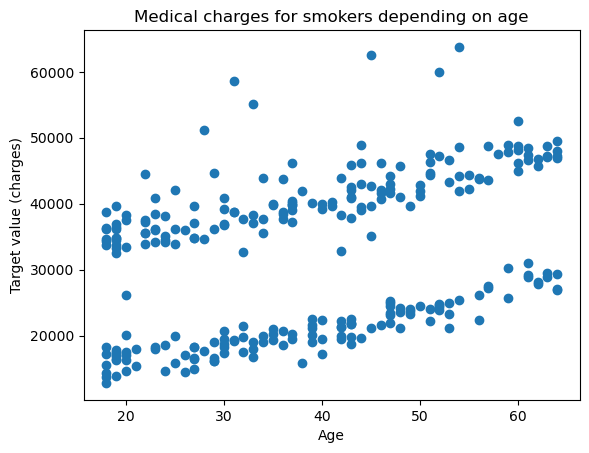

In [93]:
plt.scatter(smoker_df.age, smoker_df.charges)
plt.title('Medical charges for smokers depending on age')
plt.xlabel('Age')
plt.ylabel('Target value (charges)')

In [94]:
X_smoker = smoker_df.age
y_smoker = smoker_df.charges
X_smoker_intersept = np.c_[np.ones((X_smoker.shape[0], 1)), X_smoker]
print(X_smoker.shape, X_smoker_intersept.shape, y_smoker.shape)

(274,) (274, 2) (274,)


In [95]:
regression_smoker = LinearRegression()
regression_smoker.fit(X_smoker.to_frame(), y_smoker)

y_pred_smoker = regression_smoker.predict(X_smoker.to_frame())

rmse_smoker = rmse_my(y_smoker, y_pred_smoker, regression_smoker.coef_[0], regression_smoker.intercept_)
print(f'Smoker: mean={y_smoker.mean()}, std={y_smoker.std()}')

Params: (w=305.2376021098288, b=20294.128126915966), RMSE = 10711.00334810241
Smoker: mean=32050.23183153284, std=11541.547175589121


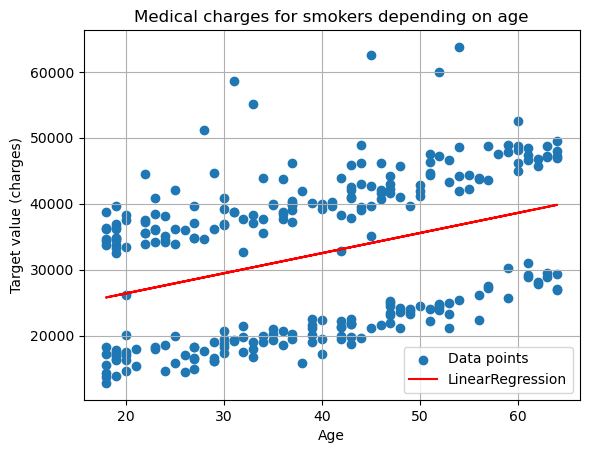

In [96]:
plt.scatter(X_smoker, y_smoker, label='Data points')
plt.plot(X_smoker, y_pred_smoker, color='red', label='LinearRegression')
plt.title('Medical charges for smokers depending on age')
plt.xlabel('Age')
plt.ylabel('Target value (charges)')
plt.legend()
plt.grid(True)

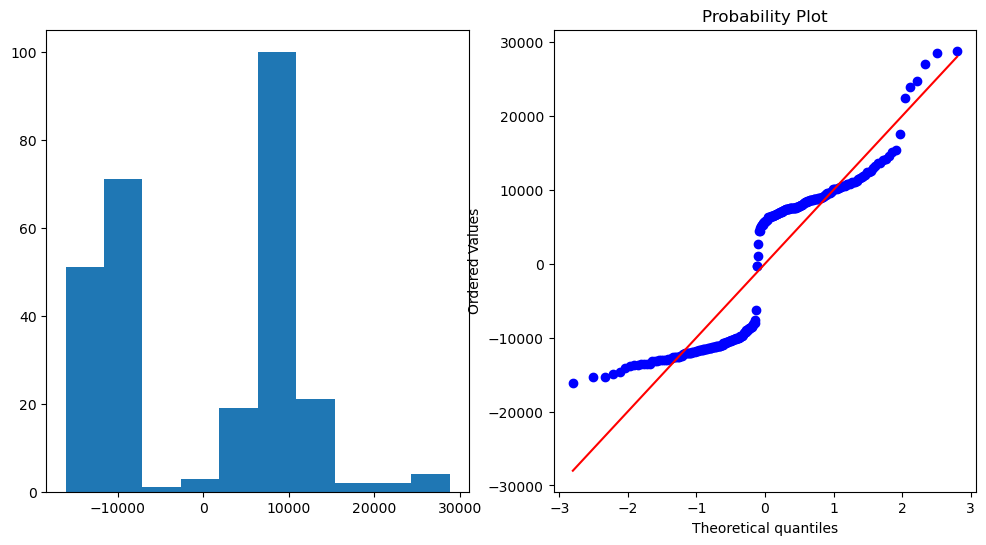

In [97]:
residuals_plot(y_smoker, y_pred_smoker)
# residuals_plot(y_smoker, y_pred_smoker)

### Висновки ДЗ 2

Для курців ми отримали лінійну модель з параметрами: w=305.2376021098288, b=20294.128126915966

В поточному вигляді - дана модель **погана** та її **НЕ варто** використовувати в компанії 

- Модель вловлює загальну тенденцію, що зі збільшенням віку медичні витрати зростають
- значення RMSE  = 10711.00 є дуже великим у порівнянні із середнім значенням витрат для курців (32050.23) та стандартним відхиленням (11541.54), що вказує на значну похибку. Помилка майже така саме як і стандартне відхилення.

- Але ми можемо бачити що на графіку розсіювання спостерігаються два чіткі кластери, але наша поточна модель погано працює для кожного з них. Наша лінія розташована "між" цими двома хмарами точок
- Робимо припущення, що вік це не єдиний фактор який варто врахувати


**Припущення щодо покращення:**
- розбити дані на підкластери та для кожного з них побудувати окрему модель. 
